In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from colorama import Fore

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats
import math

from tqdm.notebook import tqdm
from copy import deepcopy

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import optuna
from optuna import Trial, visualization

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">Tabular Playground Series 📚 - Feb 2021 📈</p>

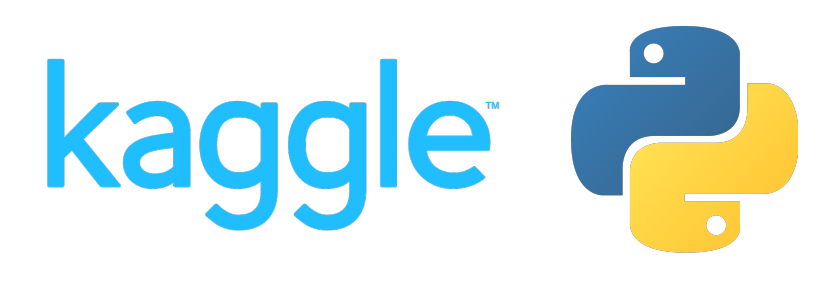

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">Table of Content</p>

* [1. Data visualization 📊](#1)
    * [1.1 Target](#1.1)
    * [1.2 Numerical Columns](#1.2)
    * [1.3 Categorical Columns](#1.3)
* [2. Feature Engineering 🔧](#2)
* [3. Base Model ⚙️](#3)
    * [3.1 XGBoost](#3.1)
    * [3.2 LGBM](#3.2)
    * [3.3 LGBM: Cross-Validation](#3.3)
* [4. Optuna Optimization: LGBM ⚙️](#4)
    * [4.1 Study Visualization 📈](#4.1)
    * [4.2 Optuna Submission 📝](#4.2)
* [5. H2O AutoML 🧮](#5)
    * [5.1 H2O AutoML Submission 📝](#5.1)
* [6. LGBM Optimized CrossValidatied](#6)
* [7. Fianl Submission](#7)

In [ ]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/test.csv')
sub_df = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2021/sample_submission.csv')

train_df.head()

In [ ]:
feature_cols = train_df.drop(['id', 'target'], axis=1).columns

## Getting all the data that are not of "object" type. 
numerical_columns = train_df[feature_cols].select_dtypes(include=['int64','float64']).columns
categorical_columns = train_df[feature_cols].select_dtypes(exclude=['int64','float64']).columns

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_indexs = train_df.index
test_indexs = test_df.index

df =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
df = df.drop('id', axis=1)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">1. Data visualization 📊</p>

In [ ]:
df.info()

<a id='1.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">1.1 Target Variable</p>

In [ ]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

f.suptitle('Target', fontsize=16)
g = sns.kdeplot(train_df['target'], shade=True, label="%.2f"%(train_df['target'].skew()), ax=axes[0])
g = g.legend(loc="best")
stats.probplot(train_df['target'], plot=axes[1])
sns.boxplot(x='target', data=train_df, orient='h', ax=axes[2]);

plt.tight_layout()
plt.show()

<a id='1.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">1.2 Numerical Variables</p>

In [ ]:
num_rows, num_cols = 4,4
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12))
f.suptitle('Distribution of Features', fontsize=16)

for index, column in enumerate(df[numerical_columns].columns):
    i,j = (index // num_cols, index % num_cols)
    g = sns.kdeplot(train_df[column], color="m", shade=True, label="%.2f"%(train_df[column].skew()), ax=axes[i,j])
    g = g.legend(loc="best")

f.delaxes(axes[3, 2])
f.delaxes(axes[3, 3])
plt.tight_layout()
plt.show()

In [ ]:
corr = df[numerical_columns].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(14, 14))

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1)
# yticks
plt.yticks(rotation=0)
plt.show()

As we can see, there is no high correlation between variables

<a id='1.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">1.3 Categorical Variables</p>

In [ ]:
num_rows, num_cols = 3,4
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12))
#f.suptitle('Distribution of Features', fontsize=16)

for index, column in enumerate(df[categorical_columns].columns):
    i,j = (index // num_cols, index % num_cols)
    sns.histplot(x=column, data=df, ax=axes[i,j])

f.delaxes(axes[2, 2])
f.delaxes(axes[2, 3])
plt.tight_layout()
plt.show()

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">2. Feature Engineering 🔧</p>

### Some manual fixes

In [ ]:
def modify_df(df):
    df['cat4'] = df['cat4'].apply(lambda x: x if x == 'B' else 'Z')
    df['cat5'] = df['cat5'].apply(lambda x: x if x in ['B', 'D'] else 'Z')
    df['cat6'] = df['cat6'].apply(lambda x: x if x == 'A' else 'Z')
    df['cat7'] = df['cat7'].apply(lambda x: x if x in ['E', 'D'] else 'Z')
    df['cat8'] = df['cat8'].apply(lambda x: x if x in ['E', 'C', 'G', 'A'] else 'Z')
    
    df['cont001'] = df['cont8'] * df['cont0']
    df['cont002'] = df['cont9'] * df['cont0']
    df['cont003'] = df['cont9'] * df['cont5']
    df['cont004'] = df['cont8'] * df['cont5']
    df['cont005'] = df['cont2'] * df['cont4']
    df['cont006'] = df['cont1'] * df['cont3']
    df['cont007'] = df['cont13'] * df['cont1']

    return df

mod_train_df = modify_df(train_df.copy())
mod_test_df = modify_df(test_df.copy())

### Label Encoder
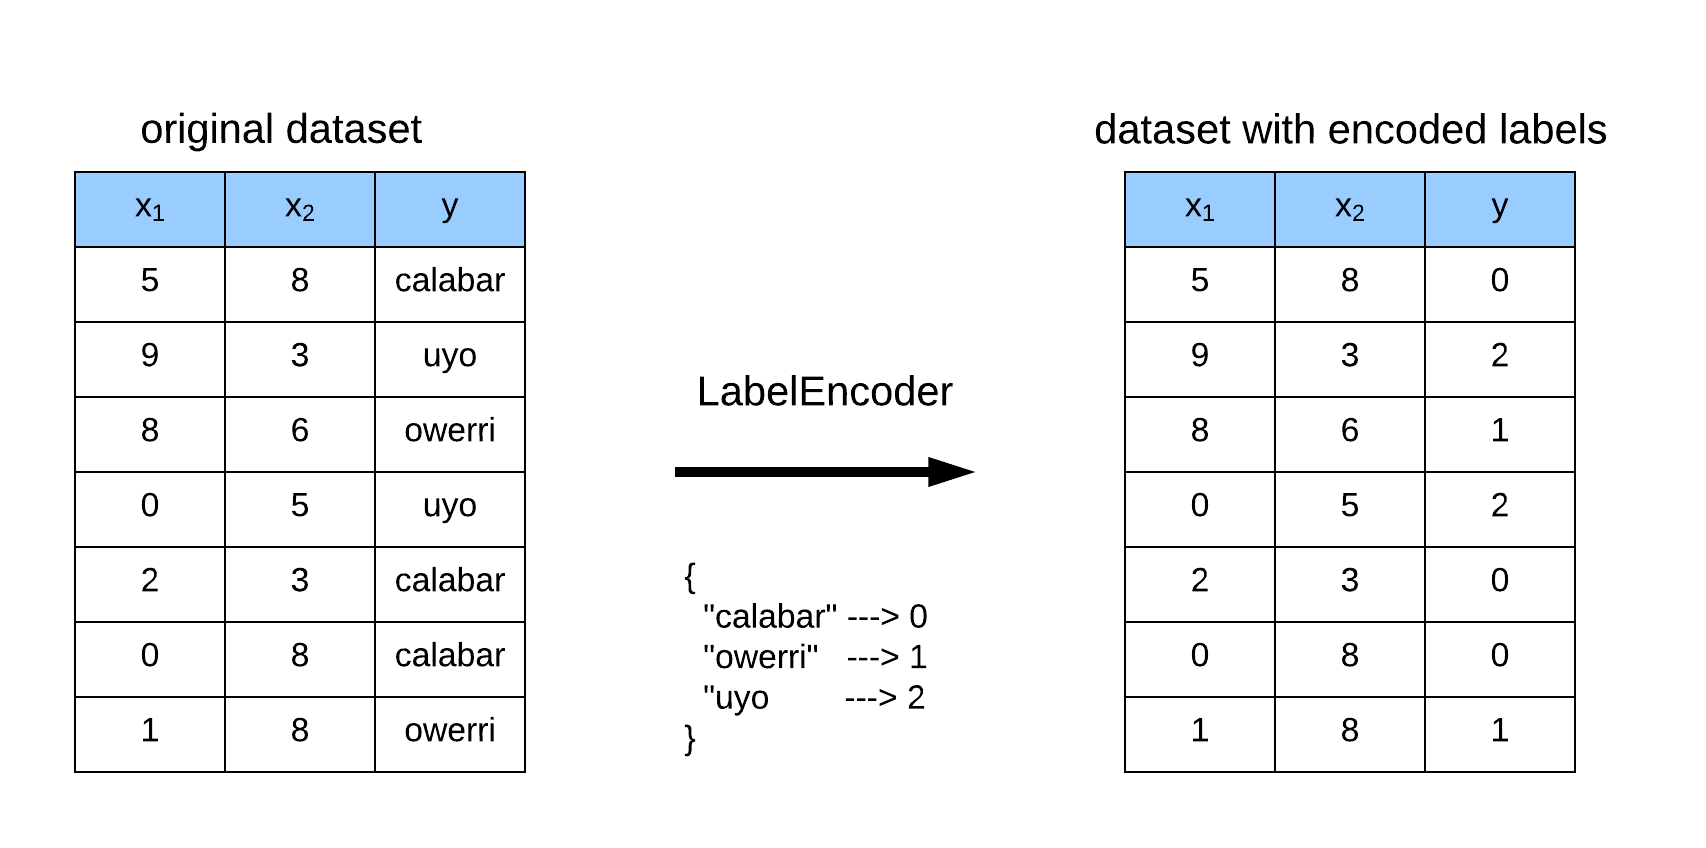

In [ ]:
for feature in categorical_columns:
    le = LabelEncoder()
    le.fit(train_df[feature])
    train_df[feature] = le.transform(train_df[feature])
    test_df[feature] = le.transform(test_df[feature])

for feature in categorical_columns:
    le = LabelEncoder()
    le.fit(mod_train_df[feature])
    mod_train_df[feature] = le.transform(mod_train_df[feature])
    mod_test_df[feature] = le.transform(mod_test_df[feature])

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">3. Base Model ⚙️</p>

In [ ]:
x = train_df[feature_cols]
y = train_df['target']

feature_cols_mod = mod_train_df.drop(['id', 'target'], axis=1).columns
xmod, ymod = mod_train_df[feature_cols_mod], mod_train_df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.1 Base XGBoost</p>

In [ ]:
# Instantiate model with 100 decision trees
clf = XGBRegressor(random_state=42, tree_method='gpu_hist')

clf.fit(x_train, y_train)

In [ ]:
# Use the forest's predict method on the test data
predictions = clf.predict(x_test)

score_rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(Fore.GREEN + 'Base XGBoost RMSE: {}'.format(score_rmse))

In [ ]:
sub_xgb_base = clf.predict(test_df[feature_cols])

<a id='3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.2 Base LGBM</p>

In [ ]:
# Instantiate model with 100 decision trees
clf = LGBMRegressor(random_state=42, device='gpu')

clf.fit(x_train, y_train)

In [ ]:
# Use the forest's predict method on the test data
predictions = clf.predict(x_test)

score_rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(Fore.GREEN + 'Base LGBM RMSE: {}'.format(score_rmse))

<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.2 Base LGBM Cross Validation</p>

In [ ]:
train_oof = np.zeros((300000,))
test_preds = 0
train_oof.shape

In [ ]:
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(x, y))):
        tmp_train_df, tmp_val_df = x.iloc[train_ind][feature_cols], x.iloc[val_ind][feature_cols]
        train_target, val_target = y[train_ind], y[val_ind]
        
        model = LGBMRegressor(random_state=42, device='gpu')
        model.fit(tmp_train_df, train_target, eval_set=[(tmp_val_df, val_target)], verbose=False)
        temp_oof = model.predict(tmp_val_df)
        temp_test = model.predict(test_df[feature_cols])

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

In [ ]:
sub_df['target'] = test_preds
sub_df.to_csv('submission_lgbm_cv.csv', index=False)
sub_df.head()

sub_lgbm_cv = test_preds

<a id='3.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.4 Optimized XGBoost 1 Cross Validation</p>

In [ ]:
xgb_params = {
    'booster':'gbtree',
    'n_estimators':20000,
    'max_depth':5, 
    'eta':0.008,
    'gamma':3.5,
    'objective':'reg:squarederror',
    'verbosity':0,
    'subsample':0.75,
    'colsample_bytree':0.35,
    'reg_lambda':0.23,
    'reg_alpha':0.52,
    'scale_pos_weight':1,
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'seed': 42,
    'tree_method':'gpu_hist',
    'gpu_id':0
}

In [ ]:
train_oof = np.zeros((300000,))
test_preds = 0
train_oof.shape

NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(x, y))):
        tmp_train_df, tmp_val_df = x.iloc[train_ind][feature_cols], x.iloc[val_ind][feature_cols]
        train_target, val_target = y[train_ind], y[val_ind]
        
        model = XGBRegressor(**xgb_params)
        model.fit(
            tmp_train_df, 
            train_target, 
            eval_set=[(tmp_val_df, val_target)], 
            early_stopping_rounds = 50, 
            verbose = False
        )
        
        temp_oof = model.predict(tmp_val_df)
        temp_test = model.predict(test_df[feature_cols])

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

In [ ]:
sub_df['target'] = test_preds
sub_df.to_csv('submission_xgb_cv_optimized.csv', index=False)
sub_df.head()

sub_xgb_cv_optimized = test_preds

<a id='3.5'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.5 Optimized XGBoost 2 Cross Validation</p>

In [ ]:
xgb_params = {
    'booster':'gbtree',
    'n_estimators':10000,
    'max_depth':7, 
    'eta':0.01,
    'gamma':1.8,
    'objective':'reg:squarederror',
    'verbosity':0,
    'subsample':0.85,
    'colsample_bytree':0.4,
    'lambda':2.7,
    'alpha':6,
    'scale_pos_weight':1,
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'seed': 42,
    'tree_method':'gpu_hist',
    'gpu_id':0
}

In [ ]:
train_oof = np.zeros((300000,))
test_preds = 0
train_oof.shape

NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(xmod, ymod))):
        tmp_train_df, tmp_val_df = xmod.iloc[train_ind][feature_cols_mod], xmod.iloc[val_ind][feature_cols_mod]
        train_target, val_target = ymod[train_ind], ymod[val_ind]
        
        model = XGBRegressor(**xgb_params)
        model.fit(
            tmp_train_df, 
            train_target, 
            eval_set=[(tmp_val_df, val_target)], 
            early_stopping_rounds = 50, 
            verbose = False
        )
        
        temp_oof = model.predict(tmp_val_df)
        temp_test = model.predict(mod_test_df[feature_cols_mod])

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

In [ ]:
sub_df['target'] = test_preds
sub_df.to_csv('submission_xgb_mod_cv_optimized.csv', index=False)
sub_df.head()

sub_xgb_mod_cv_optimized = test_preds

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">4. Optuna Optimization: LGBM ⚙️</p>

In [ ]:
def objective(trial,data=x,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'device':'gpu',  # Use GPU acceleration
        'metric': 'rmse',
        'random_state': 42,
        'reg_lambda': trial.suggest_loguniform(
            'reg_lambda', 1e-3, 10.0
        ),
        'reg_alpha': trial.suggest_loguniform(
            'reg_alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.3,0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17,20]
        ),
        'min_child_samples': trial.suggest_int(
            'min_child_samples', 1, 300
        ),
        'num_leaves': trial.suggest_int(
            'num_leaves', 15, 120
        ),
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], early_stopping_rounds=300, verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.trials_dataframe().head()

<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.1 Study visualization 📈</p>

In [ ]:
# plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [ ]:
# plot feature importance for algorithm parameters
visualization.plot_param_importances(study)

In [ ]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [ ]:
# finally plot best parameters
study.best_params

<a id='4.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.2 Optimized LGBM 📝</p>

In [ ]:
best_params = {
    'reg_lambda': 0.015979956459638782,
    'reg_alpha': 9.103977313355028,
    'colsample_bytree': 0.3,
    'subsample': 1.0,
    'learning_rate': 0.009,
    'n_estimators': 3000,
    'max_depth': 15,
    'min_child_samples': 142,
    'num_leaves': 84,
    'random_state': 42, 
    'device': 'gpu',
}

# Instantiate model with 100 decision trees
clf = LGBMRegressor(**best_params)

clf.fit(x_train, y_train)

# Use the forest's predict method on the test data
predictions = clf.predict(x_test)

score_rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(Fore.GREEN + 'Base LGBM RMSE: {}'.format(score_rmse))

<a id='4.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.3 Optuna Submission 📝</p>

In [ ]:
sub_preds = clf.predict(test_df[feature_cols])

sub_df['target'] = sub_preds
sub_df.to_csv('submission_lgbm_optuna.csv', index=False)
sub_df.head()

sub_lgbm_optuna = sub_preds

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">5. Optimized LGBM CrossValidated 🧮</p>

In [ ]:
lgbm_params = {
    "random_state": 2021,
    "metric": "rmse",
    "n_jobs": -1,
    "cat_feature": [x for x in range(len(categorical_columns))],
    "early_stopping_round": 150,
    "reg_alpha": 6.147694913504962,
    "reg_lambda": 0.002457826062076097,
    "colsample_bytree": 0.3,
    "learning_rate": 0.01,
    "max_depth": 30,
    "num_leaves": 100,
    "min_child_samples": 275,
    "n_estimators": 30000,
    "cat_smooth": 40.0,
    "max_bin": 512,
    "min_data_per_group": 100,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "cat_l2": 12.0,
}

In [ ]:
train_oof = np.zeros((300000,))
test_preds = 0
train_oof.shape

NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(x, y))):
        tmp_train_df, tmp_val_df = x.iloc[train_ind][feature_cols], x.iloc[val_ind][feature_cols]
        train_target, val_target = y[train_ind], y[val_ind]
        
        model = LGBMRegressor(**lgbm_params)
        model.fit(
            tmp_train_df, 
            train_target, 
            eval_set=[(tmp_val_df, val_target)],
            early_stopping_rounds = 100,
            verbose=False
        )
        
        temp_oof = model.predict(tmp_val_df)
        temp_test = model.predict(test_df[feature_cols])

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

In [ ]:
sub_df['target'] = test_preds
sub_df.to_csv('submission_lgbm_cv_optimized.csv', index=False)
sub_df.head()

sub_lgbm_cv_optimized = test_preds

### Modified dataframe

In [ ]:
train_oof = np.zeros((300000,))
test_preds = 0
train_oof.shape

NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(xmod, ymod))):
        tmp_train_df, tmp_val_df = xmod.iloc[train_ind][feature_cols_mod], xmod.iloc[val_ind][feature_cols_mod]
        train_target, val_target = ymod[train_ind], ymod[val_ind]
        
        model = LGBMRegressor(**lgbm_params)
        model.fit(
            tmp_train_df, 
            train_target, 
            eval_set=[(tmp_val_df, val_target)],
            early_stopping_rounds = 100,
            verbose=False
        )
        
        temp_oof = model.predict(tmp_val_df)
        temp_test = model.predict(mod_test_df[feature_cols_mod])

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

In [ ]:
sub_df['target'] = test_preds
sub_df.to_csv('submission_lgbm_mod_cv_optimized.csv', index=False)
sub_df.head()

sub_lgbm_mod_cv_optimized = test_preds

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">6. H2O AutoML 🧮</p>

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

In [ ]:
train_hf = h2o.H2OFrame(train_df)
test_hf = h2o.H2OFrame(test_df)

predictors = list(feature_cols)
response = 'target'

# Split into train and test
train, valid = train_hf.split_frame(ratios=[.8], seed=1234)

In [ ]:
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=200,
    exclude_algos = ["DeepLearning", "DRF"],
    seed=42,
)

In [ ]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=train,
        validation_frame=valid
)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
lb = lb.as_data_frame()
lb['model_type'] = lb['model_id'].apply(lambda x: x.split('_')[0])
fig = px.bar(
    lb, 
    x='model_id',
    y='rmse',
    color='model_type'
)
fig.show()

In [ ]:
print('The model performance in RMSE: {}'.format(aml.leader.rmse(valid=True)))
print('The model performance in MAE: {}'.format(aml.leader.mae(valid=True)))

<a id='5.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">5.1 H2O AutoML Submission 📝</p>

In [ ]:
preds = aml.predict(test_hf).as_data_frame()
preds.head()

In [ ]:
sub_df['target'] = preds['predict']
sub_df.to_csv('submission_h2o.csv', index=False)
sub_df.head()

sub_automl = preds['predict']

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">7. Final Submission</p>

In [ ]:
sub1 = 0.3*sub_xgb_cv_optimized + 0.3*sub_lgbm_cv_optimized + 0.4*sub_lgbm_optuna
sub2 = 0.4*sub_xgb_cv_optimized + 0.4*sub_lgbm_cv_optimized + 0.2*sub_lgbm_optuna
sub3 = 0.3*sub_xgb_cv_optimized + 0.4*sub_lgbm_cv_optimized + 0.3*sub_lgbm_optuna

sub4 = 0.3*sub_xgb_cv_optimized + 0.3*sub_lgbm_cv_optimized + 0.3*sub_lgbm_optuna + 0.1*sub_automl
sub5 = 0.3*sub_xgb_cv_optimized + 0.3*sub_lgbm_cv_optimized + 0.2*sub_lgbm_optuna + 0.2*sub_automl

sub6 = 0.5*sub_lgbm_mod_cv_optimized + 0.5*sub_xgb_mod_cv_optimized
sub7 = 0.7*sub_lgbm_mod_cv_optimized + 0.3*sub_xgb_mod_cv_optimized

sub8 = 0.2*sub_xgb_cv_optimized + 0.2*sub_lgbm_cv_optimized + 0.3*sub_lgbm_mod_cv_optimized + 0.3*sub_xgb_mod_cv_optimized
sub9 = 0.1*sub_xgb_cv_optimized + 0.1*sub_lgbm_cv_optimized + 0.4*sub_lgbm_mod_cv_optimized + 0.4*sub_xgb_mod_cv_optimized
sub10 = 0.1*sub_xgb_cv_optimized + 0.2*sub_lgbm_cv_optimized + 0.4*sub_lgbm_mod_cv_optimized + 0.3*sub_xgb_mod_cv_optimized

sub11 = 0.5*sub_xgb_cv_optimized + 0.5*sub_lgbm_cv_optimized
sub12 = 0.6*sub_xgb_cv_optimized + 0.4*sub_lgbm_cv_optimized
sub13 = 0.4*sub_xgb_cv_optimized + 0.6*sub_lgbm_cv_optimized

sub14 = 0.2*sub_xgb_cv_optimized + 0.7*sub_lgbm_cv_optimized + 0.1*sub_lgbm_mod_cv_optimized
sub14 = 0.2*sub_xgb_cv_optimized + 0.7*sub_lgbm_cv_optimized + 0.1*sub_xgb_mod_cv_optimized

In [ ]:
sub_df['target'] = sub1
sub_df.to_csv('submission_01.csv', index=False)

sub_df['target'] = sub2
sub_df.to_csv('submission_02.csv', index=False)

sub_df['target'] = sub3
sub_df.to_csv('submission_03.csv', index=False)

sub_df['target'] = sub4
sub_df.to_csv('submission_04.csv', index=False)

sub_df['target'] = sub5
sub_df.to_csv('submission_05.csv', index=False)

sub_df['target'] = sub6
sub_df.to_csv('submission_06.csv', index=False)

sub_df['target'] = sub7
sub_df.to_csv('submission_07.csv', index=False)

sub_df['target'] = sub8
sub_df.to_csv('submission_08.csv', index=False)

sub_df['target'] = sub9
sub_df.to_csv('submission_09.csv', index=False)

sub_df['target'] = sub10
sub_df.to_csv('submission_10.csv', index=False)

sub_df['target'] = sub11
sub_df.to_csv('submission_11.csv', index=False)

sub_df['target'] = sub12
sub_df.to_csv('submission_12.csv', index=False)

sub_df['target'] = sub13
sub_df.to_csv('submission_13.csv', index=False)

sub_df['target'] = sub14
sub_df.to_csv('submission_14.csv', index=False)